In [70]:
# from main import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import yaml
import argparse

def load_configuration(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
        config = argparse.Namespace(**config)
    return config

def parse_scan_log(scan_log_path=Path('/scratch/project_462000451/daniel/AUGUQ/scanfiles0002/scan.log')):
    # config_path = Path('/users/danieljordan/GENE_UncertaintyQuantification_NeuralNetworkSurrogate/code/config.yaml')
    # config = load_configuration(config_path)
    # scan_log_path = Path(config.diagdir, 'scan.log')
    growthrate = []
    frequency = []
    df = pd.read_csv(scan_log_path, sep='|',skiprows=1, names=['Run','omt2','omt1','kymin','Eiganvalues'])
    for i in range(len(df)):
        split = df['Eiganvalues'][i].lstrip().rstrip().split(' ')      
        growthrate.append(split[0])
        frequency.append(split[-1])
    df['growthrate'] = growthrate
    df['frequency'] = frequency
    df = df.drop(columns=['Run','Eiganvalues'])
    print('psl')
    return df

def plot_vs_ky(df, var_name='growthrate', omt1=2.096616, omt2=4.040331, xlog=True, ylog=True, ysymlog=False):
    mask = np.array(df['omt1']==omt1) * np.array(df['omt2']==omt2)
    var_df = df[var_name][mask]
    kymin_df = df['kymin'][mask]
    kymin = np.asarray(kymin_df,dtype='float')
    var = np.asarray(var_df,dtype='float')
        
    #remove nan's
    nan_mask = np.invert(np.isnan(var))
    kymin = kymin[nan_mask]
    var = var[nan_mask]

    print("KYMIN",kymin)
    print("VAR",var)
    plt.plot(kymin,var, label=f"Ion Grad T = {omt1} , Electron Grad T = {omt2}")
    plt.xlabel(r'$k_y$')
    var_name_symbol = {'frequency':r"$\omega_y$", 'growthrate':r"$\gamma_y$"}
    var_name_title = {'frequency':"Dispersion Relation", 'growthrate':"Growthrate Spectrum"}
    plt.ylabel(var_name_symbol[var_name])
    plt.title(var_name_title[var_name])
    if xlog: plt.xscale('log')
    if ylog: plt.yscale('log')
    if ysymlog: plt.yscale('symlog')
    # plt.legend()
    plt.show()





psl
KYMIN [ 0.09990833  0.1522413   0.1998167   0.2521496   0.299725    0.3520579
  0.3996333   0.4995416   0.59945     0.6993583   0.7992666   0.8991749
  1.          1.2         1.4         1.5         1.6         1.8
  2.          3.          4.          5.          6.          7.
  8.          9.         10.5        12.         14.         16.
 18.         24.         30.         36.         42.         50.        ]
VAR [0.073 0.121 0.165 0.212 0.252 0.291 0.321 0.365 0.389 0.392 0.381 0.36
 0.332 0.275 0.27  0.315 0.363 0.464 0.57  1.102 1.57  1.977 2.35  2.712
 3.06  3.406 3.931 4.453 5.065 5.635 6.054 6.87  6.582 5.455 3.612 0.515]


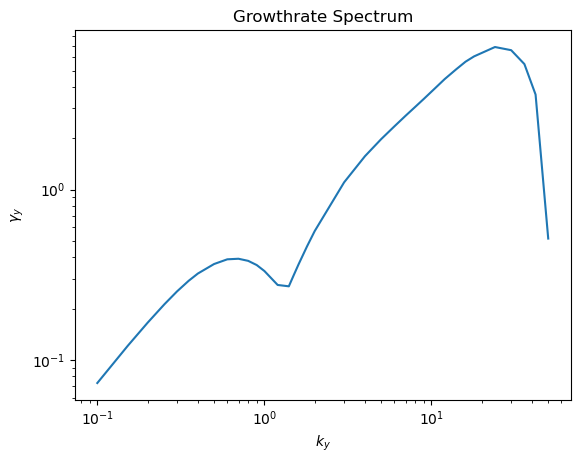

In [71]:
logdir = "~/Data/scan2.log"
    
df = parse_scan_log(logdir)
omt1 = pd.unique(df['omt1'])
# for i in range(len(omt1)):
plot_vs_ky(df, var_name='growthrate', omt1=omt1[2])

KYMIN [ 0.09990833  0.1522413   0.1998167   0.2521496   0.299725    0.3520579
  0.3996333   0.4995416   0.59945     0.6993583   0.7992666   0.8991749
  1.          1.2         1.4         1.5         1.6         1.8
  2.          3.          4.          5.          6.          7.
  8.          9.         10.5        12.         14.         16.
 18.         24.         30.         36.         42.         50.        ]
VAR [  0.034   0.041   0.041   0.039   0.043   0.054   0.072   0.126   0.196
   0.273   0.35    0.423   0.492   0.606  -0.854  -0.913  -0.973  -1.092
  -1.211  -1.824  -2.435  -3.004  -3.514  -3.965  -4.381  -4.792  -5.393
  -6.003  -6.804  -7.674  -8.54  -11.408 -14.299 -17.018 -19.259 -21.234]


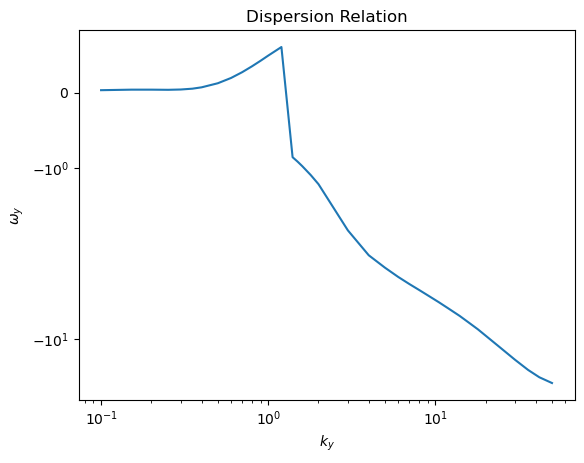

KYMIN [ 0.09990833  0.1522413   0.1998167   0.2521496   0.299725    0.3520579
  0.3996333   0.4995416   0.59945     0.6993583   0.7992666   0.8991749
  1.          1.2         1.4         1.5         1.6         1.8
  2.          3.          4.          5.          6.          7.
  8.          9.         10.5        12.         14.         16.
 18.         24.         30.         36.         42.         50.        ]
VAR [  0.034   0.041   0.041   0.039   0.043   0.054   0.072   0.126   0.196
   0.273   0.35    0.423   0.492   0.606  -0.854  -0.913  -0.973  -1.092
  -1.211  -1.824  -2.435  -3.004  -3.514  -3.965  -4.381  -4.792  -5.393
  -6.003  -6.804  -7.674  -8.54  -11.408 -14.299 -17.018 -19.259 -21.234]


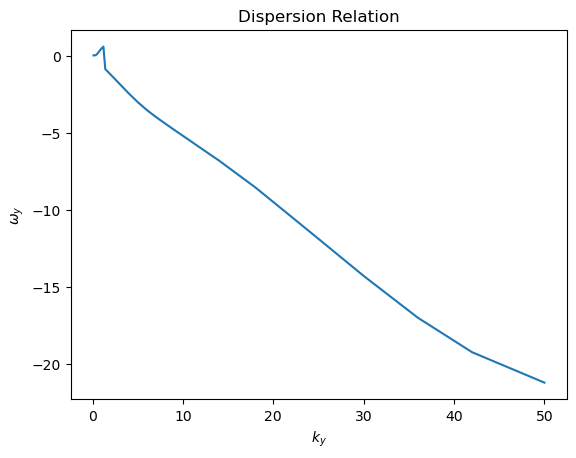

In [67]:
# omt1 = pd.unique(df['omt1'])
# for i in range(len(omt1)):
plot_vs_ky(df, var_name='frequency', omt1=omt1[2], xlog=True, ylog=True, ysymlog=True)
plot_vs_ky(df, var_name='frequency', omt1=omt1[2], xlog=False, ylog=False)


psl


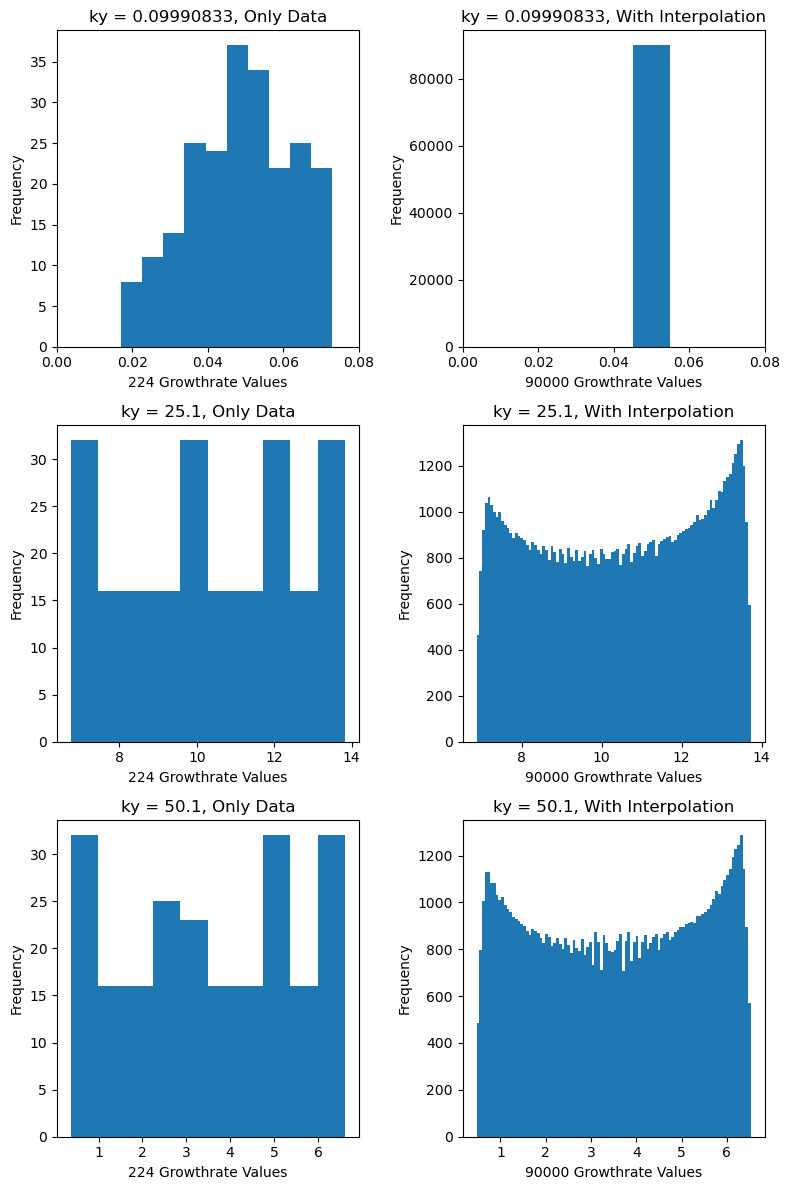

In [9]:
from sklearn import svm 
import numpy.ma as ma

logdir = "~/Data/scan3.log" #Path('/scratch/project_462000451/daniel/AUGUQ/scanfiles0003/scan.log')

df2 = parse_scan_log(logdir)

def growthrate_distribution(df, kymin, ax=False):
    gr=np.asarray(df['growthrate'][df['kymin']==kymin], dtype='float')
    if ax==False:
        plt.hist(gr,density=False, bins=10)
        plt.ylabel('Frequency')
        plt.xlabel(f'{len(gr)} Growthrate Values')
        plt.title(f'ky = {kymin}')
        plt.show()
    else:
        ax.hist(gr,density=False, bins=10)
        ax.set_ylabel('Frequency')
        ax.set_xlabel(f'{len(gr)} Growthrate Values')
        ax.set_title(f'ky = {kymin}, Only Data')
kys=pd.unique(df2['kymin'])



def growthrate_distribution_interp(df, kymin, ax=False):
    df_ky = df[df['kymin']==kymin]
    data = list(zip(np.asarray(df_ky['omt1'],dtype='float'),np.asarray(df_ky['omt2'],dtype='float')))
    labels = np.asarray(df_ky['growthrate'],dtype='float')
    #check for nans
    if any(np.isnan(labels)):
        mask = ~np.isnan(labels)
        #remove nans
        data = [data[i] for i in range(len(mask)) if mask[i]]
        labels = labels[mask]
    #training on all the data
    regressor = svm.SVR()
    regressor.fit(data,labels)
    
    omt1 = np.linspace(np.min(df['omt1']), np.max(df['omt1']), 300)
    omt2 = np.linspace(np.min(df['omt2']), np.max(df['omt2']), 300)
    grid = np.meshgrid(omt1, omt2)
    # converting the grid into an array of points
    input_points = np.array(grid).reshape(2, -1).T
    growthrates_pred = regressor.predict(input_points)
    if ax==False:
        plt.hist(growthrates_pred,density=False, bins=100)
        plt.ylabel('Frequency')
        plt.xlabel(f'{len(growthrates_pred)} Growthrate Values')
        plt.title(f'ky = {kymin}')
        plt.show()
    else:
        ax.hist(growthrates_pred,density=False, bins=100)
        ax.set_ylabel('Frequency')
        ax.set_xlabel(f'{len(growthrates_pred)} Growthrate Values')
        ax.set_title(f'ky = {kymin}, With Interpolation')


figGRdist, [(ax1,ax2),(ax3,ax4),(ax5,ax6)] = plt.subplots(3,2, figsize=(2*4,3*4))
growthrate_distribution(df2, kys[0], ax=ax1)
ax1.set_xlim(0,0.08)
growthrate_distribution(df2, kys[1], ax=ax3)
growthrate_distribution(df2, kys[2], ax=ax5)
growthrate_distribution_interp(df2, kys[0], ax=ax2)
ax2.set_xlim(0,0.08)
growthrate_distribution_interp(df2, kys[1], ax=ax4)
growthrate_distribution_interp(df2, kys[2], ax=ax6)
figGRdist.tight_layout()
plt.show()

# mask = np.isnan(labels)

# #removing NANs
# data = [data[i] for i in range(len(mask)) if mask[i]]
# labels = ma.masked_array(labels, mask)

# print(len(data))
# print(len(labels))

